[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drbob-richardson/stat220/blob/main/Lecture_Code/Code_04_01_Estimations.ipynb)



# Estimation Notebook


## Setup

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, norm, binom
from scipy.optimize import minimize


rng = np.random.default_rng(42)

def show():
    plt.tight_layout(); plt.show()

def aic(loglik, k):
    return -2*loglik + 2*k



## 1) Exponential Model (new data)
- Generate positive data from an Exponential.
- Write the log-likelihood $\ell(\lambda)$ and evaluate at a few $\lambda$.
- Plot $\ell(\lambda)$ and show the MLE.
- Histogram with fitted density.


AIC (lower is better):
  Binomial(n=10): 1003.97
  Normal:         911.39
  Exponential:    744.62


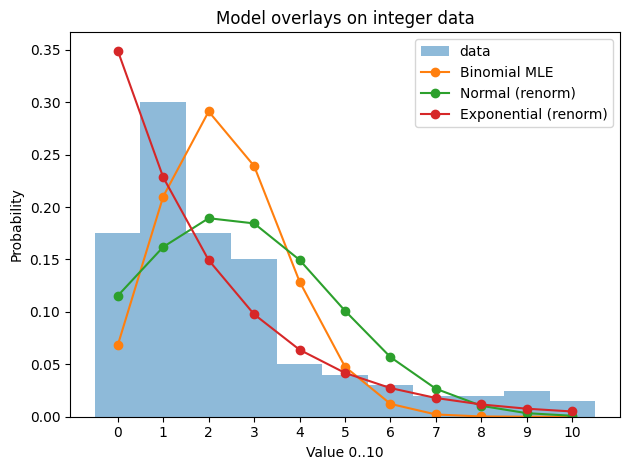

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm, expon

# Data
y   = np.clip(np.round(rng.exponential(scale=2.2, size=200)).astype(int), 0, 10)
ntr = 10

# --- MLEs (closed form) ---
p_hat   = np.sum(y) / (ntr * len(y))
mu_hat  = np.mean(y)
sig_hat = np.sqrt(np.mean((y - mu_hat)**2))
lam_hat = len(y) / np.sum(y)

# --- Log-likelihoods using SciPy pmf/pdf directly ---
ll_b = np.sum(np.log(binom.pmf(y, ntr, p_hat)))
ll_n = np.sum(np.log(norm.pdf(y, mu_hat, sig_hat)))
ll_e = np.sum(np.log(expon.pdf(y, scale=1/lam_hat)))

# --- AIC ---
def aic(loglik, k): return -2*loglik + 2*k
AIC_binom = aic(ll_b, 1)
AIC_norm  = aic(ll_n, 2)
AIC_exp   = aic(ll_e, 1)

print("AIC (lower is better):")
print(f"  Binomial(n=10): {AIC_binom:.2f}")
print(f"  Normal:         {AIC_norm:.2f}")
print(f"  Exponential:    {AIC_exp:.2f}")

# --- Overlay plot ---
plt.figure()
bins = np.arange(-0.5, 10.5+1, 1.0)
plt.hist(y, bins=bins, density=True, alpha=0.5, label="data")

k = np.arange(0, 11)
plt.plot(k, binom.pmf(k, ntr, p_hat), marker="o", label="Binomial MLE")

pdf_n = norm.pdf(k, mu_hat, sig_hat)
pdf_n = pdf_n / np.sum(pdf_n)  # renormalize to sum=1 over 0..10
plt.plot(k, pdf_n, marker="o", label="Normal (renorm)")

pdf_e = expon.pdf(k, scale=1/lam_hat)
pdf_e = pdf_e / np.sum(pdf_e)
plt.plot(k, pdf_e, marker="o", label="Exponential (renorm)")

plt.xticks(k)
plt.xlabel("Value 0..10"); plt.ylabel("Probability")
plt.title("Model overlays on integer data")
plt.legend()
plt.tight_layout()
plt.show()



## 2) Normal Model (two views)
- **(a) $\mu$ given $\sigma$ known**: $\hat\mu=\bar x$.
- **(b) $\sigma$ given $\mu$ known**: $\hat\sigma^2=\frac{1}{n}\sum(x_i-\mu)^2$.
- Plot log-likelihood vs the parameter; histogram + fitted Normal.


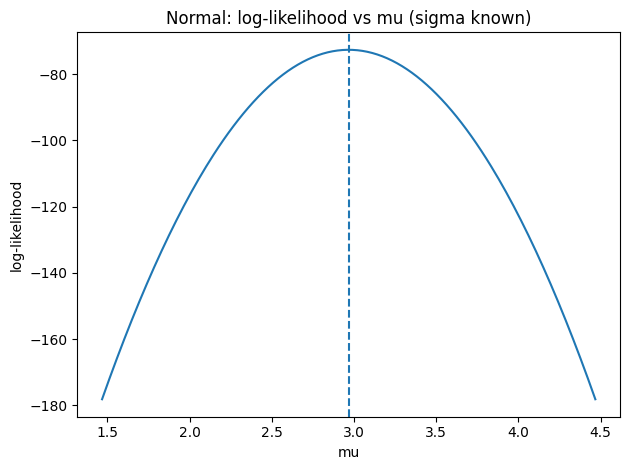

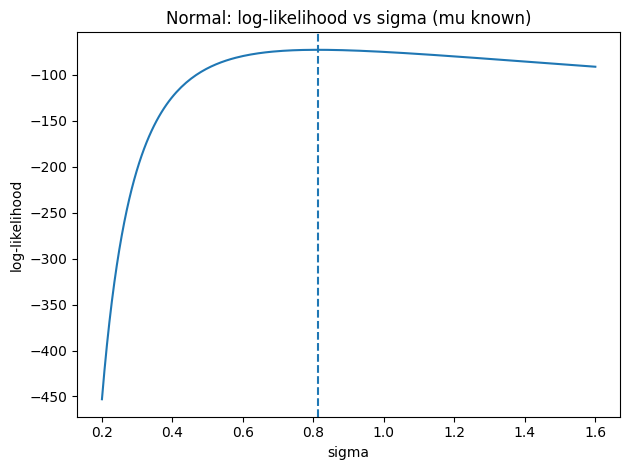

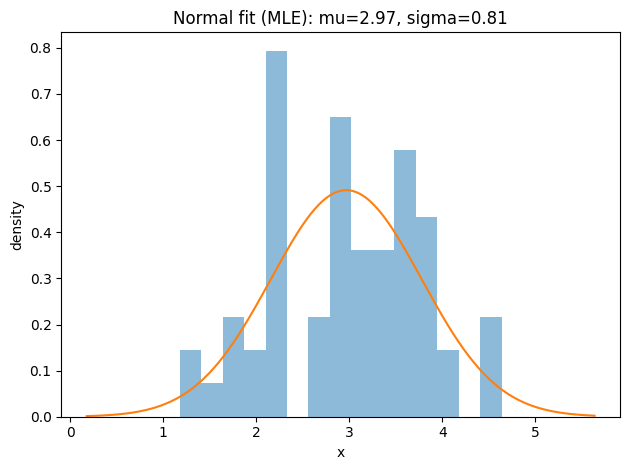

In [10]:

x_norm = rng.normal(loc=3.0, scale=0.8, size=60)
n = len(x_norm); xbar = float(np.mean(x_norm)); sigma_known = 0.8

def ll_norm_mu(mu, sigma=sigma_known):
    return np.sum(np.log(norm.pdf(x_norm, mu, sigma_known)))

mu_hat = xbar
mu_grid = np.linspace(mu_hat-1.5, mu_hat+1.5, 200)
plt.figure(); plt.plot(mu_grid, [ll_norm_mu(m) for m in mu_grid]); plt.axvline(mu_hat, ls="--")
plt.xlabel("mu"); plt.ylabel("log-likelihood"); plt.title("Normal: log-likelihood vs mu (sigma known)"); show()

mu_known = xbar
def ll_norm_sigma(sigma, mu=mu_known):
    return np.sum(np.log(norm.pdf(x_norm, mu_known, sigma)))

sigma_hat = float(np.sqrt(np.mean((x_norm - mu_known)**2)))
sig_grid = np.linspace(0.2, 1.6, 200)
plt.figure(); plt.plot(sig_grid, [ll_norm_sigma(s) for s in sig_grid]); plt.axvline(sigma_hat, ls="--")
plt.xlabel("sigma"); plt.ylabel("log-likelihood"); plt.title("Normal: log-likelihood vs sigma (mu known)"); show()

sigma_hat_joint = float(np.sqrt(np.mean((x_norm - xbar)**2)))
plt.figure(); _ = plt.hist(x_norm, bins=15, density=True, alpha=0.5)
xx = np.linspace(x_norm.min()-1, x_norm.max()+1, 400)
plt.plot(xx, norm.pdf(xx, xbar, sigma_hat_joint))
plt.xlabel("x"); plt.ylabel("density"); plt.title(f"Normal fit (MLE): mu={xbar:.2f}, sigma={sigma_hat_joint:.2f}"); show()



## Regression as Loss Minimization
- Simulate linear data.
- Define squared and absolute loss.
- Use `minimize` (or fallbacks) to fit L2 and L1; overlay lines.


L2 fit: y = 2.361 + 0.640 x
L1 fit: y = 2.388 + 0.630 x


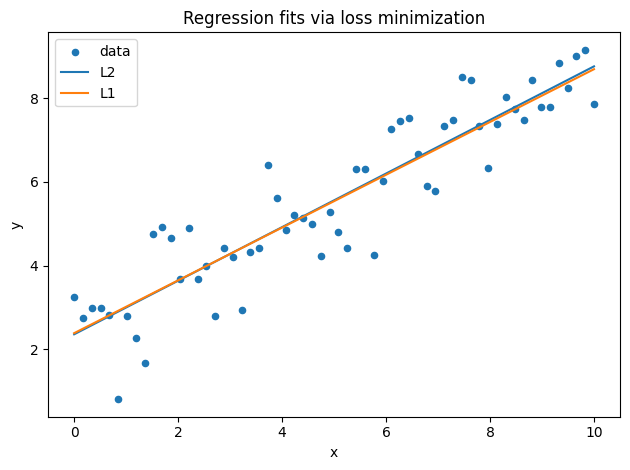

In [11]:

x = np.linspace(0, 10, 60)
y = 2.0 + 0.7*x + rng.normal(0, 1.0, size=x.size)

def loss_L2(params):
    b0, b1 = params
    r = y - (b0 + b1*x)
    return np.sum(r**2)

def loss_L1(params):
    b0, b1 = params
    r = y - (b0 + b1*x)
    return np.sum(np.abs(r))


res_L2 = minimize(loss_L2, x0=[2.0,0.6], method="Nelder-Mead")
res_L1 = minimize(loss_L1, x0=[2.0,0.6], method="Nelder-Mead")
b0_L2, b1_L2 = res_L2.x; b0_L1, b1_L1 = res_L1.x

print(f"L2 fit: y = {b0_L2:.3f} + {b1_L2:.3f} x")
print(f"L1 fit: y = {b0_L1:.3f} + {b1_L1:.3f} x")

plt.figure()
plt.scatter(x, y, s=20, label="data")
xx = np.array([x.min(), x.max()])
plt.plot(xx, b0_L2 + b1_L2*xx, label="L2")
plt.plot(xx, b0_L1 + b1_L1*xx, label="L1")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Regression fits via loss minimization")
plt.legend(); show()
